In [53]:
# %pip install torchsr

In [58]:
# import pandas as pd
# import torch 
from torchsr.models import ninasr_b0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr_model = ninasr_b0(scale=2, pretrained=True)
sr_model.to(device);

In [63]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Custom Dataset Class
class TreeDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.data_dir = data_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx, 1])
        image = read_image(img_path)
        image = image / 255.0
        # print(image.shape, image.dtype)
        label = self.dataframe.iloc[idx, 0]
        # print(label, img_path)
        image = sr_model(image.to(device))[0]
        if self.transform:
            image = self.transform(image)

        return image, label

# Load the dataset
def load_data(csv_file):
    df = pd.read_csv(csv_file, sep='\t')
    df[df.columns[1]] = df[df.columns[1]].map(lambda name: name.split('/')[-1])
    return train_test_split(df, test_size=0.2, random_state=42)

# Training and Validation Function
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    
    model.to(device)

    loss_dct = {
        "train": {
            "loss": [],
            "acc": []
        },
        "val": {
            "loss": [],
            "acc": []
        },
    }

    pb = tqdm(range(num_epochs))
    for epoch in pb:
        # phase
        pb_text = f'Epoch: {epoch}/{num_epochs - 1} ||'
        # print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(torch.sigmoid(outputs), dim=-1)
                    # print(outputs.shape, labels.shape)
                    loss = criterion(outputs, labels.to(dtype=torch.long))

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step(loss)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            pb_text += f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ||'
            loss_dct[phase]['loss'].append(epoch_loss)
            loss_dct[phase]['acc'].append(epoch_acc)
        pb.set_description(pb_text)
    return model, loss_dct

DATA_DIR = "data/gt_images"
train_df, val_df = load_data('data/hw_3_markup_data.txt')

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAdjustSharpness(2),
    transforms.GaussianBlur(3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Create datasets and dataloaders
train_dataset = TreeDataset(train_df, data_dir=DATA_DIR, transform=train_transform)
val_dataset = TreeDataset(val_df, data_dir=DATA_DIR, transform=val_transform)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False),
}
model = models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # For binary classification

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
# Train the model
trained_model, loss_dct = train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=100)

Epoch: 99/99 ||train Loss: 0.1213 Acc: 0.9688 ||val Loss: 0.5738 Acc: 0.7750 ||: 100%|██████████| 100/100 [09:11<00:00,  5.52s/it]


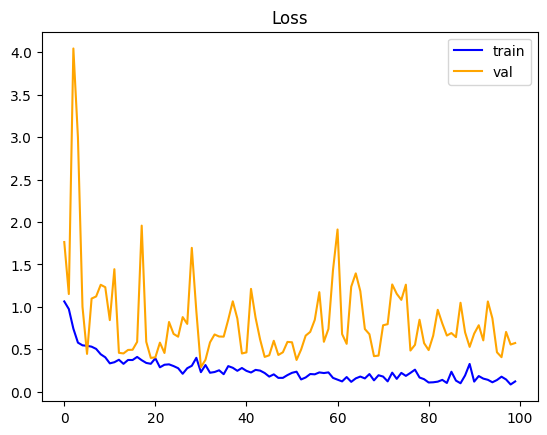

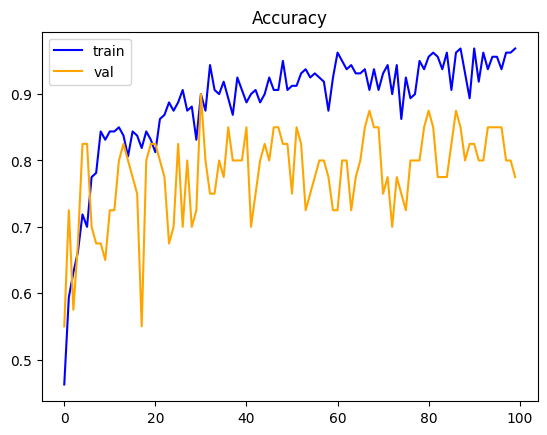

In [64]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(loss_dct['train']['loss'], color='b', label='train')
plt.plot(loss_dct['val']['loss'], color='orange', label='val')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(np.array([acc.cpu() for acc in loss_dct['train']['acc']]), color='b', label='train')
plt.plot(np.array([acc.cpu() for acc in loss_dct['val']['acc']]), color='orange', label='val')
plt.title("Accuracy")
plt.legend()
plt.show()